In [47]:
import pandas as pd

In [48]:
# Load the data
df = pd.read_csv("..\..\..\data\weather_data.csv")

In [49]:
# # Generate time-based features
# df['hour'] = pd.to_datetime(df['dt'],unit='s').dt.hour
# df['month'] = pd.to_datetime(df['dt'],unit='s').dt.month

# # Generate target temperature feature (Max temperature of the next 24 hours)
# df['temp_target'] = df['temp'].shift(-1).rolling(24).max()

# # Generate lag features (e.g., temperature 1 hour ago)
# df['temp_lag_1'] = df['temp'].shift(1)
# df['temp_lag_3'] = df['temp'].shift(3)

In [50]:
# df = pd.DataFrame({"Col1": [10, 20, 15, 30, 45]},
#                   index=pd.date_range("2020-01-01", "2020-01-05"))
# df

In [51]:
# df.shift(-1)

In [52]:
# Generate time-based features
df['hour'] = pd.to_datetime(df['dt'], unit='s').dt.hour
df['month'] = pd.to_datetime(df['dt'], unit='s').dt.month

# Convert timestamps to dates
df['date'] = pd.to_datetime(df['dt'], unit='s').dt.date

# Aggregate data by day to get the maximum temperature for each day
daily_max_temp = df.groupby('date')['temp'].max().reset_index()

# Shift the maximum temperature values by one day to create the target feature
daily_max_temp['temp_target'] = daily_max_temp['temp'].shift(-1)

# Merge the daily maximum temperature back to the original dataframe
df = df.merge(daily_max_temp[['date', 'temp_target']], on='date', how='left')

# Generate lag features (e.g., temperature 1 hour ago)
df['temp_lag_1'] = df['temp'].shift(1)
df['temp_lag_3'] = df['temp'].shift(3)

# Drop rows with NaN values in the target column
df = df.dropna(subset=['temp_target'])

In [53]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,183807,183808,183809,183810,183811,183812,183813,183814,183815,183816
dt,1072915200,1072918800,1072922400,1072926000,1072929600,1072933200,1072936800,1072940400,1072944000,1072947600,...,1723298400,1723302000,1723305600,1723309200,1723312800,1723316400,1723320000,1723323600,1723327200,1723330800
dt_iso,2004-01-01 00:00:00 +0000 UTC,2004-01-01 01:00:00 +0000 UTC,2004-01-01 02:00:00 +0000 UTC,2004-01-01 03:00:00 +0000 UTC,2004-01-01 04:00:00 +0000 UTC,2004-01-01 05:00:00 +0000 UTC,2004-01-01 06:00:00 +0000 UTC,2004-01-01 07:00:00 +0000 UTC,2004-01-01 08:00:00 +0000 UTC,2004-01-01 09:00:00 +0000 UTC,...,2024-08-10 14:00:00 +0000 UTC,2024-08-10 15:00:00 +0000 UTC,2024-08-10 16:00:00 +0000 UTC,2024-08-10 17:00:00 +0000 UTC,2024-08-10 18:00:00 +0000 UTC,2024-08-10 19:00:00 +0000 UTC,2024-08-10 20:00:00 +0000 UTC,2024-08-10 21:00:00 +0000 UTC,2024-08-10 22:00:00 +0000 UTC,2024-08-10 23:00:00 +0000 UTC
timezone,3600,3600,3600,3600,3600,3600,3600,3600,3600,3600,...,7200,7200,7200,7200,7200,7200,7200,7200,7200,7200
city_name,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,...,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm,Stockholm
lat,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,...,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323,59.329323
lon,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,...,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581,18.068581
temp,-2.22,-2.25,-2.38,-2.7,-2.56,-2.8,-3.26,-2.76,-2.8,-3.18,...,20.93,21.0,20.61,19.65,19.01,18.44,17.81,17.1,16.64,15.93
visibility,NaN,NaN,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
dew_point,-2.83,-2.99,-4.17,-4.21,-4.34,-4.58,-5.45,-5.53,-5.57,-5.23,...,10.42,11.07,10.7,9.53,10.04,10.29,10.68,11.37,11.36,11.31
feels_like,-6.94,-6.85,-5.95,-6.74,-6.67,-7.8,-8.29,-8.11,-6.45,-7.32,...,20.41,20.54,20.11,19.03,18.43,17.88,17.29,16.67,16.21,15.51


In [54]:
parsed_df = df[
    [
        'dt','dt_iso','timezone','city_name','lat','lon','temp','humidity','pressure','hour','month','temp_target','temp_lag_1','temp_lag_3'
    ]
]

In [55]:
parsed_df = parsed_df.dropna()

In [56]:
parsed_df.to_csv("processed_weather_data.csv", index=False)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import xgboost as xgb
import joblib

In [58]:
# Load the processed data
df = pd.read_csv("processed_weather_data.csv")

In [59]:
# Feature selection
X = df[['hour', 'month', 'temp','humidity','pressure','temp_lag_1','temp_lag_3']]
y = df['temp_target']

In [60]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
# XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
# Model evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.2f}°C")
rmse = root_mean_squared_error(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}°C")

Mean Absolute Error: 2.06°C
Root Mean Squared Error: 2.64°C


In [63]:
model.predict(X.iloc[[-480]])

array([23.107994], dtype=float32)

In [64]:
y.iloc[[-480]]

183334    23.53
Name: temp_target, dtype: float64

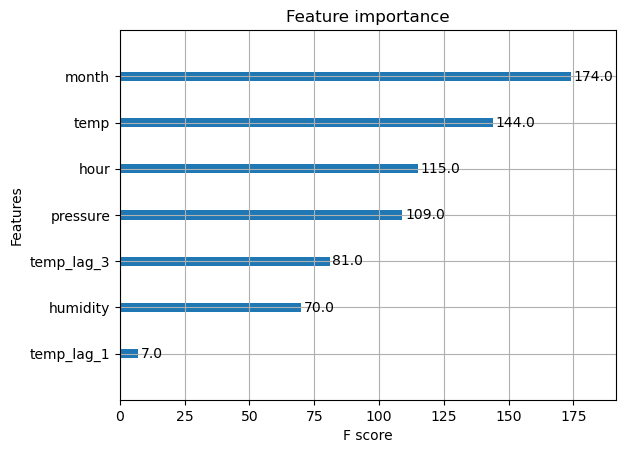

In [65]:
#Examine feature importance to determine which features can be pruned
import matplotlib.pyplot as plt

xgb.plot_importance(model)
plt.show()

In [66]:
# Save the model
joblib.dump(model, "weather_forecasting_model_stockholm_xgb_day.pkl")

['weather_forecasting_model_stockholm_xgb_day.pkl']

In [21]:
#Load the model
# model = joblib.load("weather_forecasting_model_stockholm_xgb_day.pkl")